# Hierarchical clustering

Hierarchical clustering is a common technique used in unsupervised learning. Because hierarchical clustering is a process that requires considerable machine power, we recommend using GPUs to process the data. Therefore, this chapter assumes that the analysis is performed using Google Colab and also narrows the scope of the analysis.

The following flow of explanation is provided.

- What is hierarchical clustering?
- Mathematical background of hierarchical clustering
- Let's actually try it

If you are using Google Colab, click "Runtime" > "Change Runtime Type" and select "GPU" under Hardware Accelerator.

## Step1: Import library

In [2]:
!nvidia-smi

Fri Apr 19 07:53:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 19 07:53:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')



Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!pip install rasterio
!pip install earthengine-api --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import glob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.4/340.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 0.1.398
    Uninstalling earthengine-api-0.1.398:
      Successfully uninstalled earthengine-api-0.1.398


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step2: Search scene and extract required data

To authenticate to get data from GEE's API, you need to register an account with GEE.
If you have not yet registered, you can generate a token from the following screen.

In [1]:
# Import Earth Engine Python API
import ee
# Authorize GEE and Initialization
ee.Authenticate()
ee.Initialize(project="my-first-projct-takataka")

In [7]:
# Determine satellite imagery (Landsat 8)
Landsat8 = ee.Image('LANDSAT/LC08/C01/T1_RT/LC08_106030_20170905').select(['B5', 'B4', 'B3', 'B2']) #RGBのバンドを指定

# Define the area (ex. Kushiro, Hokkaido, Japan)
region = ee.Geometry.Rectangle([144.38671875, 43.0046135, 144.45703125,  42.94033923])

In [8]:
# Export data to Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': Landsat8,
    'description': 'imagetoDrive_L8', #file name
    'folder': 'Example_Data', #folder name
    'scale': 30,
    'region': region.getInfo()['coordinates'],
    'crs': 'EPSG:4326'
})
task.start()
print('Done.')

Done.


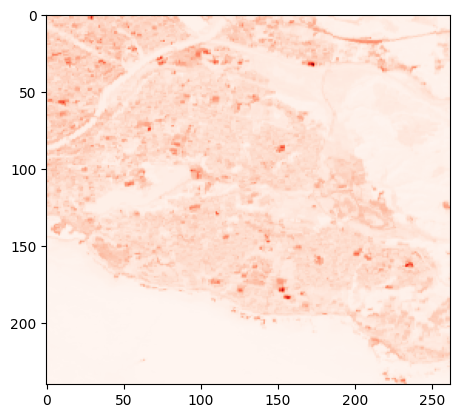

In [9]:
# Read data
with rasterio.open('/content/drive/MyDrive/Example_Data/imagetoDrive_L8.tif') as src:
    arr = src.read()

# Visualization
plt.imshow(arr[1], cmap='Reds')

In [10]:
arr[0, :, :].shape

(240, 262)

## Step3: Extract feature

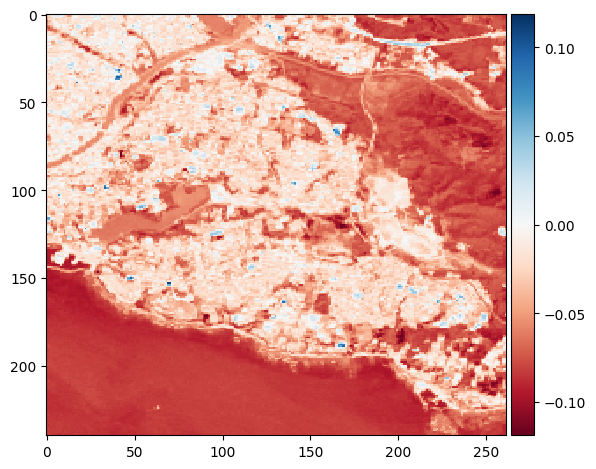

In [11]:
from skimage import io

# 正規化計算の関数を定義
def calc_normalized_index(band1, band2):
   shape = band1.shape
   assert shape == band2.shape, 'Two images are different sizes.'

   b1 = band1.flatten().astype(np.float32)
   b2 = band2.flatten().astype(np.float32)
   numer = b1 - b2
   denom = b1 + b2
   normalized_index = np.where(denom != 0, numer / denom, 0)
   return normalized_index.reshape(shape)

# 正規化指標の計算をする
calc_img = calc_normalized_index(arr[1, :, :], arr[2, :, :])

# NDVI画像を表示
io.imshow(calc_img)

In [12]:
nir_arr = arr[0, :, :].reshape([-1, 1]).astype(np.float32) #nir array
red_arr = arr[1, :, :].reshape([-1, 1]).astype(np.float32) #red array
green_arr = arr[2, :, :].reshape([-1, 1]).astype(np.float32) #green array
blue_arr = arr[3, :, :].reshape([-1, 1]).astype(np.float32) #blue array

# 特徴量のarrayを作成
features_arr = np.concatenate([nir_arr, red_arr, green_arr, blue_arr], axis=1)
features_arr

array([[10805.,  8844.,  9083.,  9774.],
       [11470.,  9541.,  9526.,  9905.],
       [11470.,  9541.,  9526.,  9905.],
       ...,
       [ 5564.,  6252.,  7459.,  8665.],
       [ 5590.,  6267.,  7489.,  8708.],
       [ 5591.,  6220.,  7402.,  8630.]], dtype=float32)

In [13]:
features_arr.shape

(62880, 4)

## Step4:Classification

Try classification by hierarchical clustering using the features. This time, we will classify the data into 5 classes.
This time we will use the cluster module of scipy. Please refer to the official documentation for details.

In [14]:
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

# Define the parater with Ward method
Z = linkage(features_arr, method='ward', metric='euclidean')
pd.DataFrame(Z)

,0,1,2,3
0,6176.0,6177.0,0.000000e+00,2.0
1,1.0,2.0,0.000000e+00,2.0
2,32702.0,32703.0,0.000000e+00,2.0
3,53.0,54.0,0.000000e+00,2.0
4,15224.0,15225.0,0.000000e+00,2.0
...,...,...,...,...
62874,125751.0,125753.0,2.591588e+05,24376.0
62875,125746.0,125752.0,2.800649e+05,14846.0
62876,125750.0,125754.0,4.271913e+05,32959.0
62877,125748.0,125756.0,1.037533e+06,48034.0


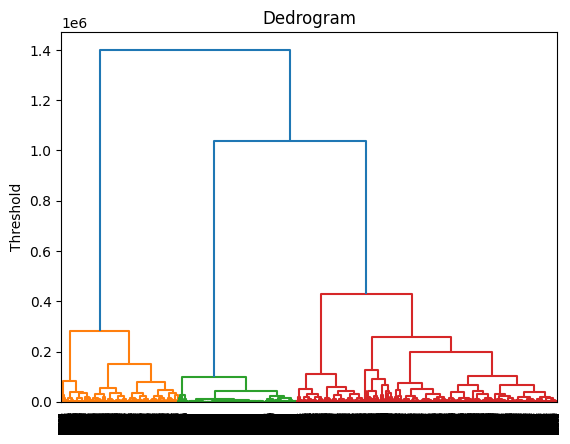

In [15]:
dendrogram(Z)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

## Step5: Get clusters with a specified number of clusters

There are two ways to create clusters: by setting an appropriate threshold or by setting a specified number of clusters. In this case, we will create clusters by specifying a specified number of clusters of four.

In [16]:
# Create a function to get clusters with a specified number of clusters.
def get_cluster_by_number(result, number):
   output_clusters = []
   x_result, y_result = result.shape
   n_clusters = x_result + 1
   cluster_id = x_result + 1
   father_of = {}
   x1 = []
   y1 = []
   x2 = []
   y2 = []
   for i in range(len(result) - 1):
       n1 = int(result[i][0])
       n2 = int(result[i][1])
       val = result[i][2]
       n_clusters -= 1
       if n_clusters >= number:
           father_of[n1] = cluster_id
           father_of[n2] = cluster_id

       cluster_id += 1

   cluster_dict = {}
   for n in range(x_result + 1):
       if n not in father_of:
           output_clusters.append([n])
           continue

       n2 = n
       m = False
       while n2 in father_of:
           m = father_of[n2]
           #print [n2, m]
           n2 = m

       if m not in cluster_dict:
           cluster_dict.update({m:[]})
       cluster_dict[m].append(n)

   output_clusters += cluster_dict.values()

   output_cluster_id = 0
   output_cluster_ids = [0] * (x_result + 1)
   for cluster in sorted(output_clusters):
       for i in cluster:
           output_cluster_ids[i] = output_cluster_id
       output_cluster_id += 1

   return output_cluster_ids

In [17]:
clusterIDs = get_cluster_by_number(Z, 4)
print(clusterIDs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Step6: Visualization of Classification Results
Finally, visualize the classification results.

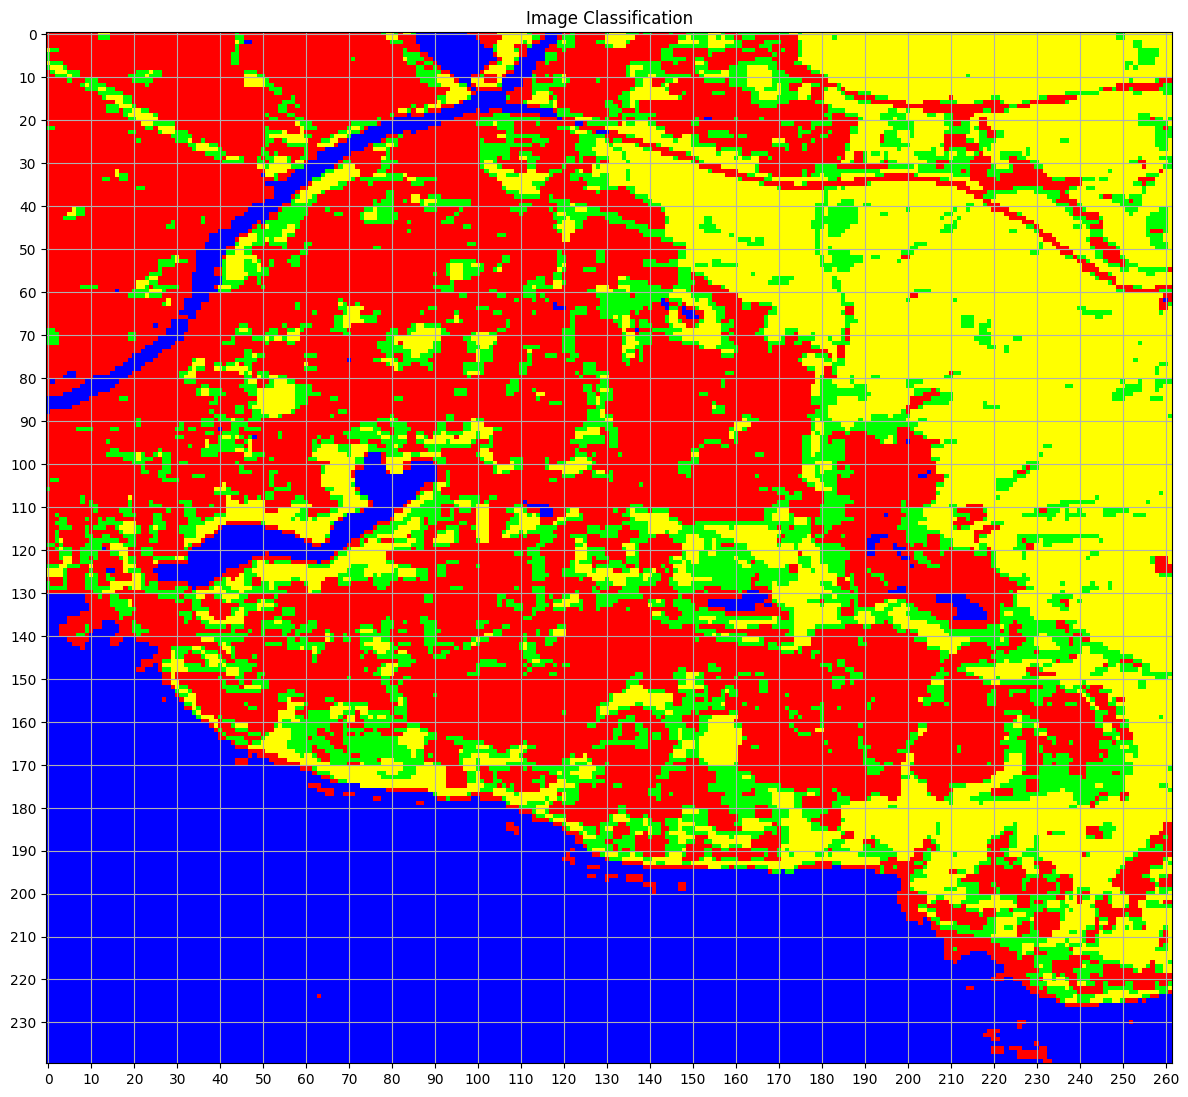

In [18]:
classified_img = np.array(clusterIDs).reshape((240, -1))

palette = np.uint8([[255, 0, 0],  [255, 255, 0], [0, 255, 0], [0, 0, 255]])

plt.figure(figsize = (12,12))
plt.xticks(np.arange(0, 600, step=10))
plt.yticks(np.arange(0, 300, step=10))
plt.grid()
plt.title('Image Classification')
io.imshow(palette[classified_img])

In [19]:
np.save('/content/drive', classified_img)


## Step7:Evaluation of the accuracy of classification

Finally, the accuracy of the classification results is evaluated. The evaluation of classification accuracy is usually expressed using a confusion matrix (also called a classification accuracy matrix or classification efficiency table). This is a tabular representation of the results of a classification problem, with the "actual class" and "predicted class" as axes.

For the validation data, we use [high-resolution land use land cover maps published by the Japan Aerospace Exploration Agency (JAXA)](https://www.eorc.jaxa.jp/ALOS/jp/dataset/lulc_j.htm) (user registration is required to download the data). We will use the 10-meter resolution data for Japan [2018 - 2020] (ver. 21.11), taking into account the timing of the satellite images used for classification.

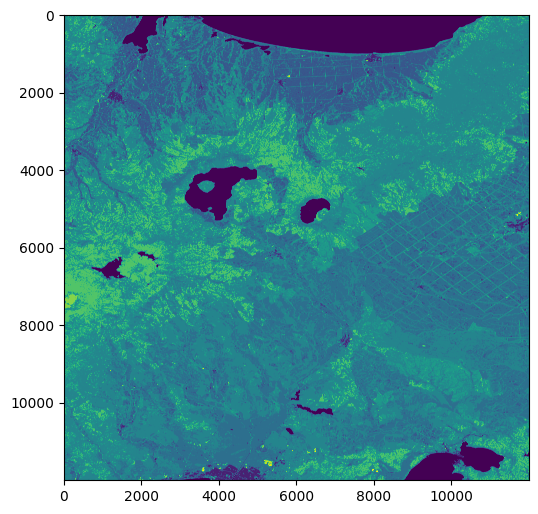

In [20]:
from osgeo import gdal, gdalconst, gdal_array

# First image
im1 = '/content/drive/MyDrive/Colab Notebooks/satelliteBook-main/notebooks/appendix_hcluster/LC_N43E144.tif'
tif1 = gdal.Open(im1, gdalconst.GA_ReadOnly) # Read image using gdal.Open
imgArray1 = tif1.ReadAsArray() # Convert image to Array information
plt.figure(figsize = (6,12))
plt.imshow(imgArray1)

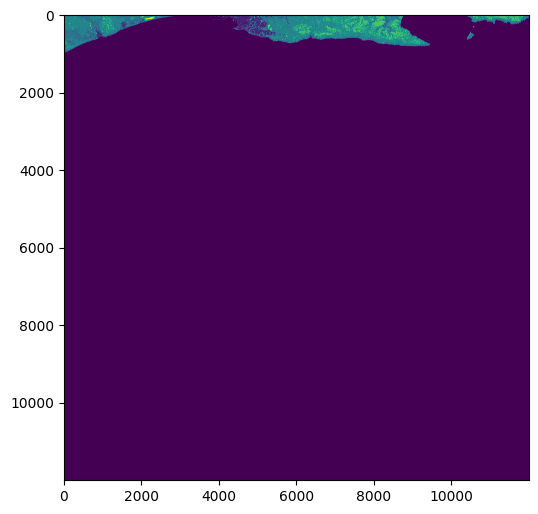

In [21]:
# Second image
im2 = '/content/drive/MyDrive/Colab Notebooks/satelliteBook-main/notebooks/appendix_hcluster/LC_N42E144.tif'
tif2 = gdal.Open(im2, gdalconst.GA_ReadOnly)
imgArray2 = tif2.ReadAsArray()
plt.figure(figsize = (6,12))
plt.imshow(imgArray2)

In [22]:
#From your environment, check "which" command to see where gdal_merge is located.

!which gdal_merge.py

/usr/local/bin/gdal_merge.py


In [23]:
import sys
sys.path.append("/usr/local/bin/")

In [24]:
# import gdal_merge
from osgeo_utils.gdal_merge import gdal_merge

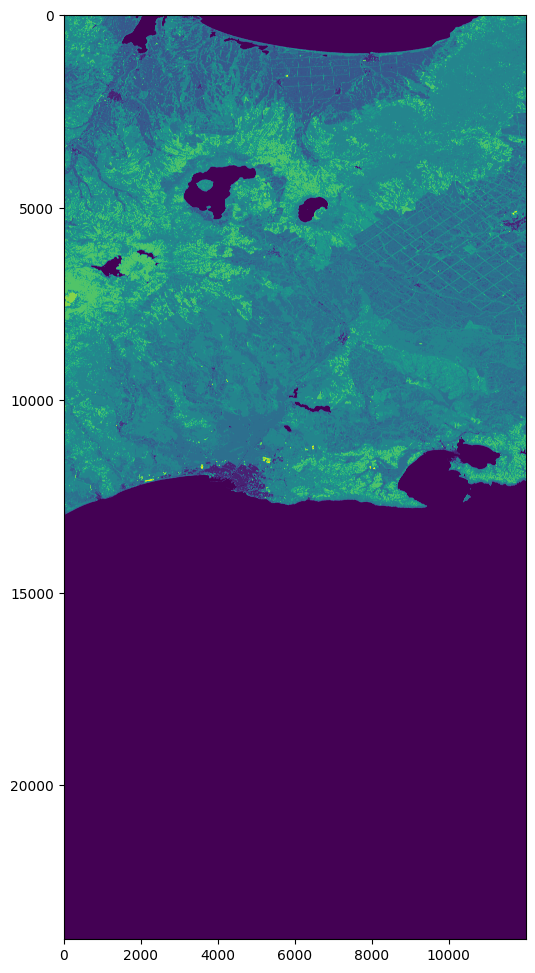

In [25]:
# Combine two validation images
# gdal_merge.main(["","-o",{output image},"-separate",{input image 1},{input image 2},{input image 3}])
# gdal_merge.main(["", "-o", "val_im.tif", im1, im2])
gdal_merge(["", "-o", "val_im.tif", im1, im2]) #update: ".main" is not longer required
# Display two images merged into one image
val_tif = gdal.Open("val_im.tif", gdalconst.GA_ReadOnly)
# val_tif = gdal.Open("/content/drive/MyDrive/Colab Notebooks/satelliteBook-main/notebooks/appendix_hcluster/val_im.tif", gdalconst.GA_ReadOnly)
imgArray_val = val_tif.ReadAsArray()
plt.figure(figsize = (6,12))
plt.imshow(imgArray_val)

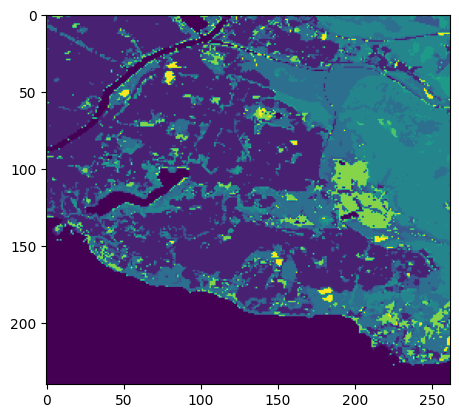

In [26]:
# Save the file with the following name
cut_val_tif_path = "cut_val_im.tif"

bbox = [144.38671875, 43.0046135, 144.45703125,  42.94033923]

# Cut the area of interest using "gdal.Translate"
# gdal.Translate(｛outpu image name｝,{input image name}, width={number of pixels in x direction}, height={number of pixels in y direction}, projWin=[xmin ymax xmax ymin], resampleAlg={nearest, average etc.})
cut_val_tif = gdal.Translate(cut_val_tif_path, val_tif, width=262, height=240, projWin=bbox, resampleAlg="nearest")
cut_val_tif = None
# Read image using gdal.Open
cut_val_tif_im = gdal.Open(cut_val_tif_path)

# Convert image to array
cut_val_tif_arr = cut_val_tif_im.ReadAsArray()
plt.imshow(cut_val_tif_arr)



In [27]:
cut_val_tif_arr.shape

(240, 262)

However, while the Landsat images were classified into 4 classes this time, the validation data were classified into 13 classes.
This needs to be reconciled.
The Landsat images were classified in order of class number: man-made objects (0), grassland/farmland (1), forest (2), and water bodies (3). The validation data is rearranged into the following classification classes

0: Unclassified

1: Water → Water body

2: Urban → Artificial

3: Rice paddy → Grassland/farmland

4: Crops → Grassland

5: Grassland → Grassland/farmland

6: Deciduous broadleaf tree (DBF) → Forest

7: Deciduous coniferous (DNF) → Forest

8: Evergreen broadleaf tree (EBF) → Forest

9: Evergreen coniferous (ENF) → Forest

10: Bare land → Grassland/farmland

11: Bamboo forest (Bamboo) → Forest

12: Solar panel → Artificial

In [28]:
# Check if there is an Unclassified
val_arr = cut_val_tif_arr.copy() # Copy and use arrays of validation data
print(np.where(val_arr == 0))

(array([], dtype=int64), array([], dtype=int64))


In [29]:
# Replace the classification class of the validation data with the Landsat classification class using np.select
val_arr = np.select([val_arr == 1, val_arr == 2, val_arr == 3, val_arr == 4, val_arr == 5, val_arr == 6, val_arr == 7, val_arr == 8,
           val_arr == 9, val_arr == 10, val_arr == 11, val_arr == 12], [3, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0])
print(val_arr)

[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [30]:
from sklearn.metrics import confusion_matrix

val_class = val_arr.flatten()
output_class = classified_img.flatten()
labels = [0, 1, 2, 3]

# confusion_matrix({validation data},{classification result data})
cm = confusion_matrix(val_class, output_class, labels=labels)

print(cm)

[[19006   705  2792   113]
 [ 4391  6536  4606   337]
 [  497  7593  1141     8]
 [  482    12    44 14617]]


In [31]:
# Column name
columns = ['都市', '草地/農地', '森林', '水域']

n = len(columns)

actual = ['正解データ'] * n
pred = ['推定結果'] * n

# Create DataFrame
cm_df = pd.DataFrame(cm, columns=[pred, columns], index=[actual, columns])

cm_df

推定結果                   
                都市 草地/農地    森林     水域
正解データ 都市     19006   705  2792    113
      草地/農地   4391  6536  4606    337
      森林       497  7593  1141      8
      水域       482    12    44  14617